# Part 1 - Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15­minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
# General
import pandas as pd
import numpy as np
import json
from pandas.io.json import json_normalize
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import math

#visulization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import classification_report
import scikitplot as skplt

import warnings
warnings.filterwarnings("ignore")

In [2]:
logins = pd.read_json('logins.json')
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
logins['count']=1

In [6]:
logins.set_index('login_time',inplace=True)
logins_15min = logins.resample('15Min').sum()

In [7]:
logins_15min.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


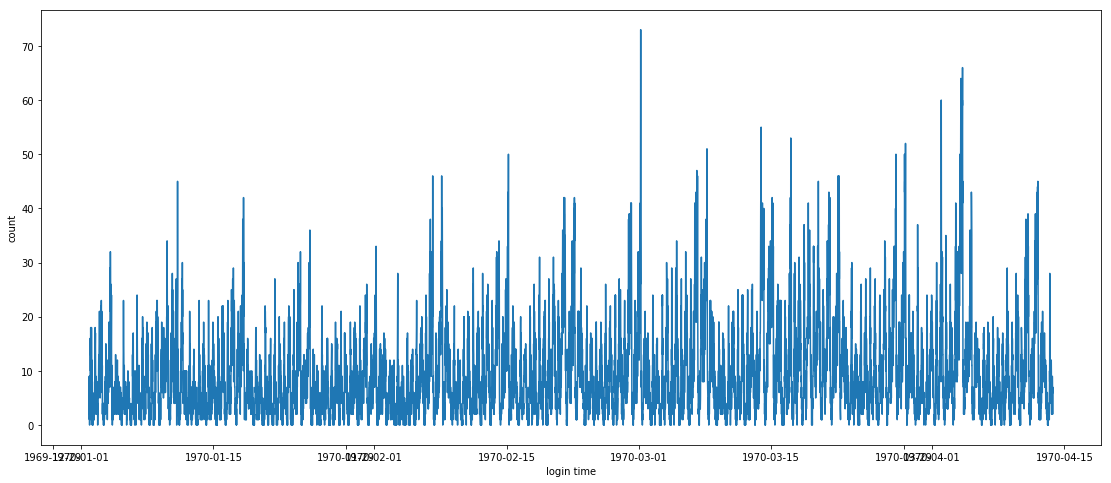

In [8]:
plt.figure(figsize=(19,8))
plt.plot(logins_15min)
plt.xlabel('login time')
plt.ylabel('count')
plt.show()

In [9]:
logins.reset_index(inplace=True)

In [10]:
logins['date']=logins['login_time'].dt.date
logins['day']=logins['login_time'].dt.dayofweek
logins['hour']=logins['login_time'].dt.hour
logins['month']=logins['login_time'].dt.month

In [11]:
logins.day = logins.day.map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
logins.month = logins.month.map({1:'January',2:'February',3:'March',4:'April'})

In [12]:
cal = calendar()
holidays = cal.holidays(start=logins.date.min(),end=logins.date.max())
logins['holiday']=logins.date.apply(lambda x: x in(holidays))

In [13]:
workingday = ['Monday','Tuesday','Wednesday','Thursday','Friday']
logins['workingday']=logins.day.isin(workingday)

In [14]:
logins.head()

,login_time,count,date,day,hour,month,holiday,workingday
0,1970-01-01 20:13:18,1,1970-01-01,Thursday,20,January,True,True
1,1970-01-01 20:16:10,1,1970-01-01,Thursday,20,January,True,True
2,1970-01-01 20:16:37,1,1970-01-01,Thursday,20,January,True,True
3,1970-01-01 20:16:36,1,1970-01-01,Thursday,20,January,True,True
4,1970-01-01 20:26:21,1,1970-01-01,Thursday,20,January,True,True


In [15]:
workingday = logins.groupby('workingday').size()

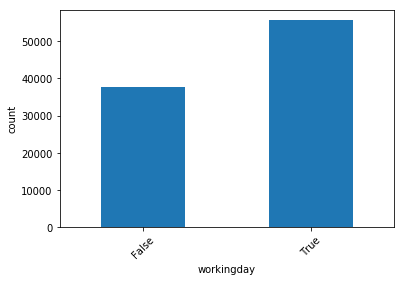

In [16]:
workingday.plot(kind='bar')
plt.ylabel('count')
plt.xticks(rotation=45)
plt.show()

people ususally login on weekdays more than weekends

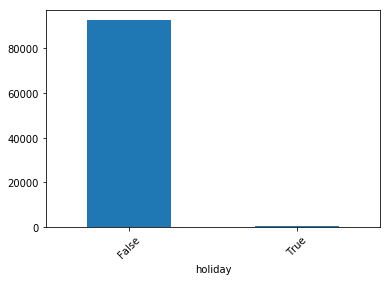

In [17]:
holiday = logins.groupby('holiday').size()
holiday.plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

people bearly login on the holidays

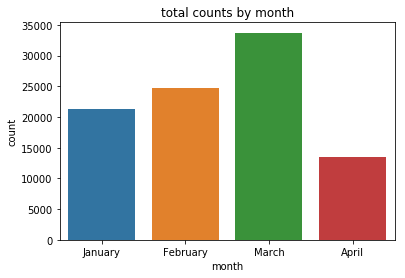

In [18]:
monthly_count = logins.groupby('month').size().to_frame('count').reset_index()
monthOrder = ["January","February","March","April"]
sns.barplot(data=monthly_count, x="month", y="count",order=monthOrder)
plt.title('total counts by month')
plt.show()

the login count keep increase from january to march, and have a big drop on April, this result may need more deep analysis.

In [19]:
hourly_count = logins.groupby(['hour','day']).size().to_frame('count').reset_index()

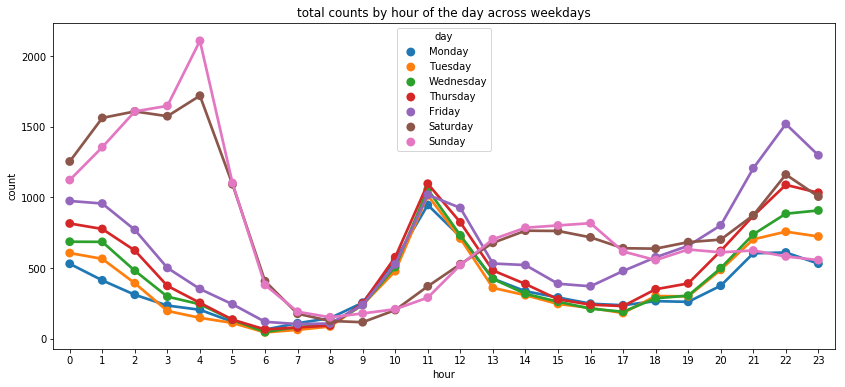

In [20]:
plt.figure(figsize=(14,6))
weekOrder =['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
sns.pointplot(x='hour',y='count',hue ='day',hue_order= weekOrder,data=hourly_count)
plt.title('total counts by hour of the day across weekdays')
plt.show()

 for the weekdays, people are usually login in at lunch time(around 11, 12) and offwork (beween 22-2)
 the heavest usage overall in in friday night 10pm and weekends eraly morning 0-5 espcially 5 am.

# Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

The Key measure I will choose is how is the weekday activity in 2 cities. Because we are already known there are more cars enter to  Gotham at night and more cars enter Metropolis during the day, choose this metric is easy to measure and do not need to wait for the reimbursing data.

I would use 2 hypothesis test:

1.H0 there will be no difference between the mean number of cars entering Metropolis during the day (6am-8pm)before   reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.
  H1 there will be a significant increase in the mean number of cars entering Metropolis during the day (6am-8pm)before reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.
  
2.H0 there will be no difference between the mean number of cars entering Gotham during the night (9pm-5am)before    reimbursements were offered and the mean number of cars two weeks after reumbursements were offered.
  H1 there will be a significant increase in the mean number of cars entering Gotham during the night (9pm-5am)before  reimbursements were offered and the mean number of cars two weeks after reimbursements were offered.
  
I will use a one-tialed z-test to determine p value for each hypothesis.

If the p-value is less than 0.05 for both tests I would reject the null hypotheses and recommend the reimbursement program continue.

If the p-value is greater than 0.05 for both tests I would fail to reject the null hypotheses and recommend that a different program be developed to increase partner driving between the two cities.

If the p-value is mixed, so only one hypothesis has a p-value less than 0.05 I would recommend that the analysis is inconclusive and that further investigation is needed.


# Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

## Exploratory Data Analysis 

In [21]:
with open('ultimate_data_challenge.json')as f:
    data = json.load(f)

In [22]:
df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [24]:
df.dtypes

avg_dist                  float64
avg_rating_by_driver      float64
avg_rating_of_driver      float64
avg_surge                 float64
city                       object
last_trip_date             object
phone                      object
signup_date                object
surge_pct                 float64
trips_in_first_30_days      int64
ultimate_black_user          bool
weekday_pct               float64
dtype: object

In [25]:
df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.median(),inplace=True)
df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.median(),inplace=True)

In [26]:
df.phone.unique()

array(['iPhone', 'Android', None], dtype=object)

In [27]:
df.phone.fillna('Not known',inplace=True)

In [28]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [29]:
pull_day = df.last_trip_date.max()

In [30]:
cut_off_day=pull_day-pd.Timedelta('30D')

In [31]:
df['active_status']= (df.last_trip_date > cut_off_day).astype(int)

In [32]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,active_status
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [33]:
df['phone'] = df['phone'].astype('category')
df['city'] = df['city'].astype('category')

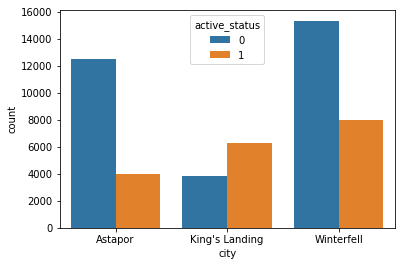

In [34]:
sns.countplot(x="city",hue="active_status",data = df)
plt.show()

peole living in winterfell and astapor are more likely to sign up first but usualy not stay acitve after.people living in King's Landing city who registered seems like to keep active.

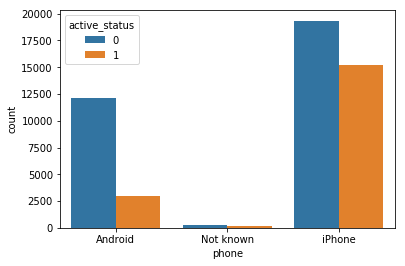

In [35]:
sns.countplot(x="phone",hue="active_status",data = df)
plt.show()

people using iPhone are more likely to keep retain

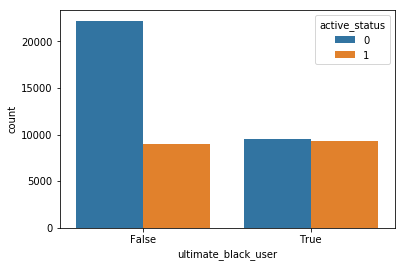

In [36]:
sns.countplot(x="ultimate_black_user",hue="active_status",data = df)
plt.show()

peole who registered as a black user are more likely keep accout active

In [37]:
df.active_status.value_counts()

0    31690
1    18310
Name: active_status, dtype: int64

In [38]:
fraction=round(18310/50000 *100,2)

In [39]:
print('{} percent of users are still retained.'.format(fraction))

36.62 percent of users are still retained.


In [40]:
df=pd.get_dummies(df,columns=['city','phone','ultimate_black_user'],drop_first=True)

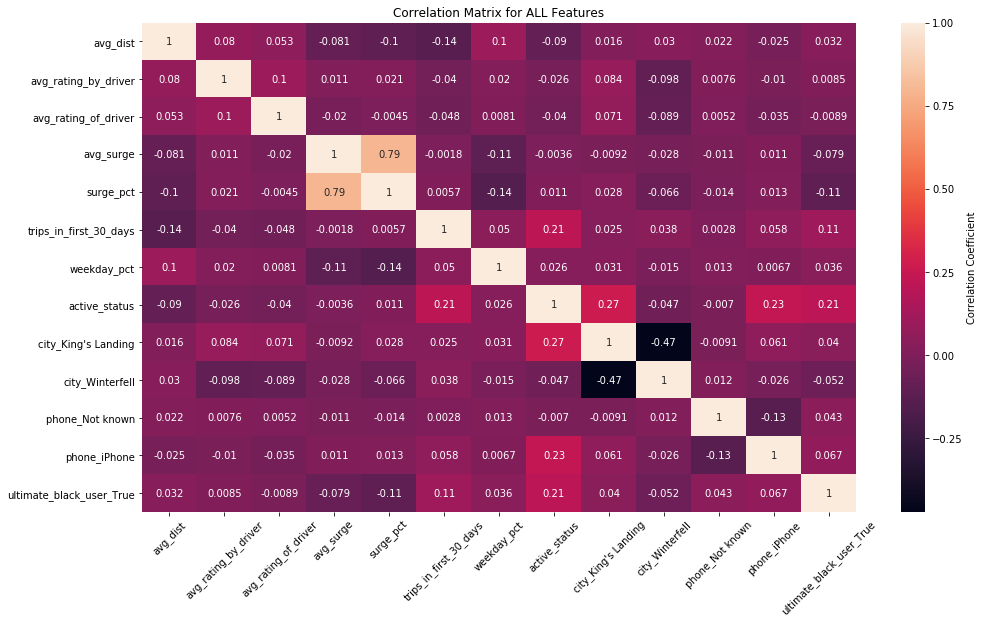

In [41]:
# overall heatmap
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(), annot=True,cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix for ALL Features")
plt.xticks(rotation=45)
plt.show()

we can see the people using iphone,living in city_king's Landing,as Ultimate black user and trips in the first 30 days of register more likely to retain.

## Machine Learning

In [42]:
model = df.drop(['last_trip_date','signup_date'],axis=1)

In [43]:
X = model.drop('active_status',axis=1)
y = model['active_status']

In [44]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

I will use a random forest model for this project because it a has high tendency to be more accurate than any base classifiers.

In [45]:
#GirdSearch
random_gird={'max_depth':[10,30,50,70],
             'min_samples_leaf':[1,2,4,6],
              'max_features':['auto','sqrt','log2']}
rf_clf = RandomForestClassifier()
rf_cv = GridSearchCV(rf_clf, random_gird,cv = 5)

In [46]:
rf_cv.fit(X_train, y_train)
print('best parameter:{}'.format(rf_cv.best_params_),'best score:{}'.format(rf_cv.best_score_))

best parameter:{'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 6} best score:0.7865428571428571


In [47]:
# fit the data with best model
rf_clf = RandomForestClassifier(max_depth=10 ,max_features= 'auto' ,min_samples_leaf= 4)
rf_clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

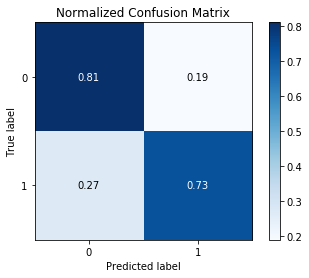

In [48]:
# Confusion Matrix
skplt.metrics.plot_confusion_matrix(rf_clf.predict(X_test), y_test, normalize=True)
plt.show()

In [49]:
# classification report
print(classification_report(rf_clf.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.86      0.81      0.84     10116
           1       0.65      0.73      0.69      4884

    accuracy                           0.79     15000
   macro avg       0.76      0.77      0.76     15000
weighted avg       0.80      0.79      0.79     15000



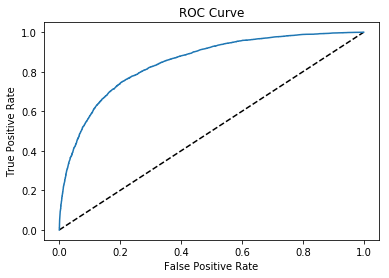

In [50]:
#plot ROC curve
y_pred_prob= rf_clf.predict_proba(X_test)[:,1]

fpr,tpr,thresholds =metrics.roc_curve(y_test,y_pred_prob)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [51]:
print('AUC:{}'.format(metrics.roc_auc_score(y_test,y_pred_prob)))

AUC:0.8484479145854292


## Important Features

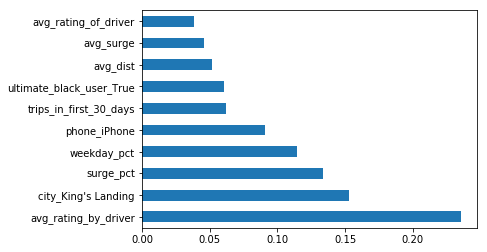

In [52]:
feature_importance= pd.Series(rf_clf.feature_importances_,index=X_train.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()

## Conclusion and Future Recommendations


The Random Forest model I build has a 79% accuracy and AUC score of 0.84.Although it was better at predicting those that were not active than predicting those that were active correctly. My main concern is how active users are defined. The idea of the "30 days cut off" based on 6 months dataset is not the clearest way to determine activate users at this point.

Based on my model, the most important features are:
- avg_rating_by_driver : The rider's average rating over all of their trips
- city_King's Landing User's that signed up in the city of King's Landing
- surge_pct the percent of trips taken with surge multiplier > 1

Avg_rating_by_driver seems like the Key Feature effects the rider to retain the servies or not.Ultimate should pay more attention on how to imporve users score for the next step. They also should create a marketing event targeted on King's Landing and Slightly adjust pricing outside of surges to encourage more users to use the service during off hours


